<a href="https://colab.research.google.com/github/elnrdfrs/article_frontiers_notebook/blob/main/frontiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
!pip3 install pingouin
!pip3 install statannot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import pingouin as pg
import sys
sys.path.append("fonctions") 

import pandas as pd
import glob
import os
#from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown as md
import processDFResultats as dfRes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from statannot import add_stat_annotation

In [57]:
listFiles=['csv/lesjak_isotrope/Lesjak_iso_asym_inv__joint_lastItr.csv',
           'csv/msseg-testing-direct/MSSEG-2_testing_asym_inv__joint_lastItr.csv', 
 'csv/msseg-testing-inv/MSSEG-2_testing_asym_inv__joint_lastItr.csv',
 'csv/msseg-training-direct/MSSEG-2_training_asym_inv__joint_lastItr.csv',
'csv/msseg-training-inv/MSSEG-2_training_asym_inv__joint_lastItr.csv',
 'csv/msseg-affine/MSSEG2-Training_resampled_affine__seq_lastItr.csv',
 'csv/msseg-affine/MSSEG2-Test_resampled_affine__seq_lastItr.csv',
           'csv/lesjak_isotrope/Lesjak_nyul_affine_seq_lastItr.csv']

listFiles=['csv/lesjak_isotrope/Lesjak_iso_asym_inv__joint_lastItr.csv',
           'csv/msseg-testing-direct/MSSEG-2_testing_asym_inv__joint_lastItr.csv', 
 'csv/msseg-testing-inv/MSSEG-2_testing_asym_inv__joint_lastItr.csv',
 'csv/msseg-training-direct/MSSEG-2_training_asym_inv__joint_lastItr.csv',
'csv/msseg-training-inv/MSSEG-2_training_asym_inv__joint_lastItr.csv',
           'csv/lesjak_isotrope/Lesjak_nyul_affine_seq_lastItr.csv']

methods = ["affine","sequential","joint"]
metrics=[ 'Dice', 'Jaccard', 'PPV',
       'TPR', 'FPR', 'LTPR', 'LFPR',  'SD', 'TPR_dilGT', 'FPR_dilGT',
       'Dice_dilGT', 'LTPR_dilGT', 'LFPR_dilGT', 'VD_dilGT', 'SD_dilGT']
metrics=[ 'Dice', 'PPV',
       'TPR', 'Dice_dilGT']
metrics=[ 'DSC', 'PPV',
       'TPR', 'local DSC']


In [58]:
dfconcat=[]
for item in glob.glob("csv/*/*.csv") :
    if item not in ['csv/msseg-affine/MSSEG2-Training_resampled_affine__seq_lastItr.csv', 'csv/msseg-affine/MSSEG2-Test_resampled_affine__seq_lastItr.csv'] :
        name=item.split("/")[1]
        df = pd.read_csv(item, sep=';')
        if len(dfconcat)==0 :
            colref=df.columns
            
        df=df.drop_duplicates()
        df.columns=[x.replace(" ","") for x in df.columns]
        df["OriginDataset"]=name
        dfconcat.append(df)


df = pd.read_csv('csv/msseg-affine/MSSEG2-Training_resampled_affine__seq_lastItr.csv', sep=';')
df=df.drop_duplicates()
df.columns=[x.replace(" ","") for x in df.columns]
df["OriginDataset"]="msseg-training-direct"
dfconcat.append(df)
df = pd.read_csv('csv/msseg-affine/MSSEG2-Training_resampled_affine__seq_lastItr.csv', sep=';')
df=df.drop_duplicates()
df.columns=[x.replace(" ","") for x in df.columns]
df["OriginDataset"]="msseg-training-inv"
dfconcat.append(df)

df = pd.read_csv('csv/msseg-affine/MSSEG2-Test_resampled_affine__seq_lastItr.csv', sep=';')
df=df.drop_duplicates()
df.columns=[x.replace(" ","") for x in df.columns]
df["OriginDataset"]="msseg-testing-direct"
dfconcat.append(df)
df = pd.read_csv('csv/msseg-affine/MSSEG2-Test_resampled_affine__seq_lastItr.csv', sep=';')
df=df.drop_duplicates()
df.columns=[x.replace(" ","") for x in df.columns]
df["OriginDataset"]="msseg-testing-inv"
dfconcat.append(df)

#df = pd.read_csv('csv/lesjak_isotrope/Lesjak_nyul_affine_seq_lastItr.csv', sep=';')
#df=df.drop_duplicates()
#df.columns=[x.replace(" ","") for x in df.columns]
#df["OriginDataset"]="lesjak_isotrope"
#dfconcat.append(df)

df=pd.concat(dfconcat)
    
df=df[~df["Lambda3"].isin([7,9])]
df=df[df["Lambda3"]==5]
df=df[df["Lambda2"]==15]
df["sens"]="direct"
df.loc[df["OriginDataset"].isin(["msseg-testing-inv","msseg-training-inv"]),"sens"]="inverse"

df["patientId"]=df["patientId"].apply(lambda x :str(x))
df=df.drop_duplicates()


df["ADMMiterations"]=df["ADMMiterations"].apply(lambda x : x.replace(" ",""))

dfraw=df.copy()
df=df[df["ADMMiterations"].isin(["0/0","1/5","5/5"])]
tr={"0/0":"affine","1/5":"sequential","5/5":"joint"}
df["Algorithm"]=df["ADMMiterations"].apply(lambda x : tr[x])
df=df.drop_duplicates()

df.rename(columns={"Dice":"DSC", 'Dice_dilGT':'local DSC' }, inplace=True)

listPatientIdWithoutEvolution=sorted(df[(df["SD"]==-1)&(df["Algorithm"]=="affine")]["patientId"].unique())
listPatientIdWithEvolution=sorted(df[(df["SD"]!=-1)&(df["Algorithm"]=="affine")&(df["OriginDataset"]!="lesjak_isotrope")]["patientId"].unique())
listPatientIdLesjack=sorted(df[df["OriginDataset"]=="lesjak_isotrope"]["patientId"].unique())
print("Patient Lesjack") 
print("Nb : ", len(listPatientIdLesjack))
print(sorted(listPatientIdLesjack))
print("Patient MSSEG avec changement") 
print("Nb : ", len(listPatientIdWithEvolution))
print(sorted(listPatientIdWithEvolution))
print("Patient MSSEG sans changement") 
print("Nb : ", len(listPatientIdWithoutEvolution))
print(sorted(listPatientIdWithoutEvolution))


Patient Lesjack
Nb :  20
['patient1', 'patient10', 'patient11', 'patient12', 'patient13', 'patient14', 'patient15', 'patient16', 'patient17', 'patient18', 'patient19', 'patient2', 'patient20', 'patient3', 'patient4', 'patient5', 'patient6', 'patient7', 'patient8', 'patient9']
Patient MSSEG avec changement
Nb :  61
['1', '100', '11', '12', '13', '16', '17', '18', '2', '20', '21', '22', '23', '24', '25', '26', '27', '29', '30', '31', '32', '33', '35', '36', '37', '39', '40', '43', '44', '46', '47', '48', '5', '53', '56', '57', '6', '60', '61', '62', '66', '67', '69', '74', '75', '77', '78', '8', '80', '81', '82', '83', '85', '86', '87', '88', '91', '94', '95', '97', '99']
Patient MSSEG sans changement
Nb :  39
['10', '14', '15', '19', '28', '3', '34', '38', '4', '41', '42', '45', '49', '50', '51', '52', '54', '55', '58', '59', '63', '64', '65', '68', '7', '70', '71', '72', '73', '76', '79', '84', '89', '9', '90', '92', '93', '96', '98']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [59]:
print("Patient Lesjack") 
listPatientIdLesjackComplet=[]
for idpat in listPatientIdLesjack :
    flag=True
    for met in methods :
        if ((df["patientId"]==idpat) & (df["Algorithm"]==met)).sum() == 0 : 
            print(idpat, met, " is missing")
            flag=False
    if flag :
          listPatientIdLesjackComplet.append(idpat)
print("Nb : ", len(listPatientIdLesjackComplet))
print(sorted(listPatientIdLesjackComplet))
print("------------------------------")
print("Patient MSSEG avec changement") 
listPatientIdWithEvolutionComplet=[]
for idpat in listPatientIdWithEvolution :
    flag=True
    for met in methods :
        for expe in ["direct","inverse"]:
            if ((df["patientId"]==idpat) & (df["Algorithm"]==met)& (df["sens"]==expe)).sum() == 0 : 
                print(idpat, met, expe, " is missing")
                #display(dfraw[(dfraw["patientId"]==idpat)& (dfraw["sens"]==expe)])
                flag=False
    if flag :
          listPatientIdWithEvolutionComplet.append(idpat)
print("Nb : ", len(listPatientIdWithEvolutionComplet))
print(sorted(listPatientIdWithEvolutionComplet))

print("------------------------------")
print("Patient MSSEG sans changement") 
listPatientIdWithoutEvolutionComplet=[]
for idpat in listPatientIdWithoutEvolution :
    flag=True
    for met in methods :
        for expe in ["direct","inverse"]:
            if ((df["patientId"]==idpat) & (df["Algorithm"]==met)& (df["sens"]==expe)).sum() == 0 : 
                print(idpat, met, expe, " is missing")
                #display(dfraw[(dfraw["patientId"]==idpat)& (dfraw["sens"]==expe)])
                
                flag=False
    if flag :
          listPatientIdWithoutEvolutionComplet.append(idpat)
print("Nb : ", len(listPatientIdWithoutEvolutionComplet))
print(sorted(listPatientIdWithoutEvolutionComplet))



Patient Lesjack
Nb :  20
['patient1', 'patient10', 'patient11', 'patient12', 'patient13', 'patient14', 'patient15', 'patient16', 'patient17', 'patient18', 'patient19', 'patient2', 'patient20', 'patient3', 'patient4', 'patient5', 'patient6', 'patient7', 'patient8', 'patient9']
------------------------------
Patient MSSEG avec changement
Nb :  61
['1', '100', '11', '12', '13', '16', '17', '18', '2', '20', '21', '22', '23', '24', '25', '26', '27', '29', '30', '31', '32', '33', '35', '36', '37', '39', '40', '43', '44', '46', '47', '48', '5', '53', '56', '57', '6', '60', '61', '62', '66', '67', '69', '74', '75', '77', '78', '8', '80', '81', '82', '83', '85', '86', '87', '88', '91', '94', '95', '97', '99']
------------------------------
Patient MSSEG sans changement
65 sequential inverse  is missing
65 joint inverse  is missing
73 sequential inverse  is missing
73 joint inverse  is missing
79 sequential inverse  is missing
79 joint inverse  is missing
Nb :  36
['10', '14', '15', '19', '28', 

In [60]:
dfvol=pd.read_csv("examVolMSSEG_training.csv")
dfvol.rename(columns={"Unnamed: 0": "patientId"},inplace=True)
dfvol
df["Vol"]=0
for i,item in dfvol.iterrows() :
    df.loc[df["patientId"]==str(item[0]),"Vol"]=item[1]
df["DetectionVolume"]=df["FPR"]*df["Vol"]/1000
df

,OriginDataset,Algorithm,patientId,Lambda1,Lambda2,Lambda3,ADMMiterations,gtDilation,DSC,Jaccard,PPV,TPR,FPR,LTPR,LFPR,VD,SD,TPR_dilGT,FPR_dilGT,local DSC,LTPR_dilGT,LFPR_dilGT,VD_dilGT,SD_dilGT,sens,Vol,DetectionVolume
0,lesjak_isotrope,sequential,patient7,70,15.0,5.0,1/5,4,0.285591,0.166583,0.232632,0.369771,0.001175,0.492063,0.875000,0.589515,7.335524,0.369771,0.000814,0.420774,0.774194,0.738281,0.242424,2.922969,direct,0,0.000000
17,lesjak_isotrope,joint,patient7,70,15.0,5.0,5/5,4,0.312928,0.185486,0.231268,0.483733,0.001548,0.523810,0.862500,1.091653,7.226825,0.483733,0.000993,0.465932,0.774194,0.745833,0.076408,2.654066,direct,0,0.000000
1,lesjak_isotrope,sequential,patient15,70,15.0,5.0,1/5,4,0.312150,0.184939,0.236733,0.458083,0.000644,0.766667,0.892019,0.935018,15.207384,0.458083,0.000564,0.555177,0.736842,0.863850,0.349779,2.802378,direct,0,0.000000
16,lesjak_isotrope,joint,patient15,70,15.0,5.0,5/5,4,0.354105,0.215144,0.251864,0.596069,0.000772,0.766667,0.886139,1.366627,14.986528,0.596069,0.000630,0.616853,0.736842,0.851485,0.067389,2.489821,direct,0,0.000000
0,lesjak_isotrope,sequential,patient19,70,15.0,5.0,1/5,4,0.438434,0.280765,0.460641,0.418269,0.002028,0.480000,0.672897,0.091984,5.772987,0.418269,0.001801,0.563237,0.666667,0.570093,0.514766,1.546959,direct,0,0.000000
16,lesjak_isotrope,joint,patient19,70,15.0,5.0,5/5,4,0.491787,0.326073,0.453184,0.537578,0.002685,0.500000,0.673077,0.186224,6.264232,0.537578,0.002282,0.651409,0.666667,0.557692,0.349490,1.305715,direct,0,0.000000
0,lesjak_isotrope,sequential,patient6,70,15.0,5.0,1/5,4,0.351310,0.213084,0.409888,0.307381,0.000230,0.500000,0.855670,0.250084,5.666007,0.307381,0.000156,0.423693,0.714286,0.752577,0.549039,2.603678,direct,0,0.000000
17,lesjak_isotrope,joint,patient6,70,15.0,5.0,5/5,4,0.382596,0.236550,0.410019,0.358611,0.000268,0.500000,0.852632,0.125379,5.637367,0.358611,0.000169,0.462307,0.714286,0.747368,0.448601,2.464615,direct,0,0.000000
0,lesjak_isotrope,sequential,patient4,70,15.0,5.0,1/5,4,0.000030,0.000015,0.000015,0.016667,0.008786,0.333333,0.995516,1110.333333,55.562472,0.016667,0.008784,0.020408,0.333333,0.991031,0.366667,83.948934,direct,0,0.000000
4,lesjak_isotrope,joint,patient4,70,15.0,5.0,5/5,4,0.000045,0.000023,0.000023,0.033333,0.011679,0.333333,0.995261,1476.300000,56.119883,0.033333,0.011676,0.034188,0.333333,0.995261,0.050000,70.987256,direct,0,0.000000


In [61]:
dfraw[(dfraw["patientId"]=='33')]

,OriginDataset,Algorithm,patientId,Lambda1,Lambda2,Lambda3,ADMMiterations,gtDilation,Dice,Jaccard,PPV,TPR,FPR,LTPR,LFPR,VD,SD,TPR_dilGT,FPR_dilGT,Dice_dilGT,LTPR_dilGT,LFPR_dilGT,VD_dilGT,SD_dilGT,sens
404,msseg-testing-inv,asym_inv_jointrien,33,70,15.0,5.0,3/5,4,0.0,0.0,0.0,0.0,0.000010,0.0,1.0,0.342657,59.432529,0.0,0.000010,0.0,0.0,1.0,1.0,-1.0,inverse
0,msseg-testing-inv,jointriennormalisation,33,70,15.0,5.0,1/5,4,0.0,0.0,0.0,0.0,0.000009,0.0,1.0,0.349650,59.407126,0.0,0.000009,0.0,0.0,1.0,1.0,-1.0,inverse
1,msseg-testing-inv,jointriennormalisation,33,70,15.0,5.0,2/5,4,0.0,0.0,0.0,0.0,0.000010,0.0,1.0,0.342657,59.432529,0.0,0.000010,0.0,0.0,1.0,1.0,-1.0,inverse
2,msseg-testing-inv,jointriennormalisation,33,70,15.0,5.0,5/5,4,0.0,0.0,0.0,0.0,0.000010,0.0,1.0,0.342657,59.432529,0.0,0.000010,0.0,0.0,1.0,1.0,-1.0,inverse
0,msseg-testing-direct,jointriennormalisation,33,70,15.0,5.0,1/5,4,0.0,0.0,0.0,0.0,0.000006,0.0,1.0,0.559441,69.655234,0.0,0.000006,0.0,0.0,1.0,1.0,-1.0,direct
1,msseg-testing-direct,jointriennormalisation,33,70,15.0,5.0,2/5,4,0.0,0.0,0.0,0.0,0.000007,0.0,1.0,0.517483,69.604395,0.0,0.000007,0.0,0.0,1.0,1.0,-1.0,direct
2,msseg-testing-direct,jointriennormalisation,33,70,15.0,5.0,5/5,4,0.0,0.0,0.0,0.0,0.000007,0.0,1.0,0.517483,69.604395,0.0,0.000007,0.0,0.0,1.0,1.0,-1.0,direct
283,msseg-testing-direct,asym_inv_jointrien,33,70,15.0,5.0,3/5,4,0.0,0.0,0.0,0.0,0.000007,0.0,1.0,0.517483,69.604395,0.0,0.000007,0.0,0.0,1.0,1.0,-1.0,direct
2,msseg-testing-direct,jointriennormalisation,33,70,15.0,5.0,3/5,4,0.0,0.0,0.0,0.0,0.000007,0.0,1.0,0.517483,69.604395,0.0,0.000007,0.0,0.0,1.0,1.0,-1.0,direct
374,msseg-testing-direct,affine_seqrien,33,0,15.0,5.0,0/0,4,0.0,0.0,0.0,0.0,0.009510,0.0,1.0,650.363636,58.115157,0.0,0.009512,0.0,0.0,1.0,1.0,-1.0,direct


In [62]:
df[df["patientId"].isin(listPatientIdWithoutEvolutionComplet+listPatientIdWithEvolutionComplet+listPatientIdLesjackComplet)].groupby(["OriginDataset","Algorithm"])[["patientId"]].count()

patientId
OriginDataset         Algorithm            
lesjak_isotrope       affine             20
                      joint              20
                      sequential         20
msseg-testing-direct  affine             57
                      joint              57
                      sequential         57
msseg-testing-inv     affine             57
                      joint              57
                      sequential         57
msseg-training-direct affine             40
                      joint              40
                      sequential         40
msseg-training-inv    affine             40
                      joint              40
                      sequential         40

---------------------
Lesjack


DSC           PPV           TPR        local DSC       
           median    mad median    mad median    mad    median    mad
Algorithm                                                            
affine      0.204  0.140  0.142  0.132  0.375  0.210     0.471  0.195
sequential  0.302  0.115  0.272  0.145  0.364  0.125     0.466  0.143
joint       0.368  0.136  0.308  0.141  0.492  0.199     0.536  0.176

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n{} & \\multicolumn{2}{l}{DSC} & \\multicolumn{2}{l}{PPV} & \\multicolumn{2}{l}{TPR} & \\multicolumn{2}{l}{local DSC} \\\\\n{} &    median &       mad &    median &       mad &    median &       mad &    median &       mad \\\\\nAlgorithm  &           &           &           &           &           &           &           &           \\\\\n\\midrule\naffine     &  0.204187 &  0.139895 &  0.141530 &  0.132209 &  0.375438 &  0.210188 &  0.471085 &  0.195497 \\\\\nsequential &  0.302005 &  0.114883 &  0.271618 &  0.144601 &  0.363503 &  0.125362 &  0.465656 &  0.142917 \\\\\njoint      &  0.368351 &  0.135832 &  0.308277 &  0.140598 &  0.492246 &  0.199384 &  0.535741 &  0.175754 \\\\\n\\bottomrule\n\\end{tabular}\n'

DSC


/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,23.0,two-sided,0.004011,0.006016,fdr_bh,-0.505771
1,Algorithm,affine,sequential,True,False,46.0,two-sided,0.050968,0.050968,fdr_bh,-0.267778
2,Algorithm,joint,sequential,True,False,0.0,two-sided,0.000143,0.000429,fdr_bh,0.278929


PPV


/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,19.0,two-sided,0.002379,0.005292,fdr_bh,-0.515686
1,Algorithm,affine,sequential,True,False,22.0,two-sided,0.003528,0.005292,fdr_bh,-0.456330
2,Algorithm,joint,sequential,True,False,53.0,two-sided,0.094909,0.094909,fdr_bh,0.055910


TPR


/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,37.0,two-sided,0.020672,0.031008,fdr_bh,-0.219054
1,Algorithm,affine,sequential,True,False,51.0,two-sided,0.080026,0.080026,fdr_bh,0.299998
2,Algorithm,joint,sequential,True,False,0.0,two-sided,0.000143,0.000429,fdr_bh,0.564553


local DSC


/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,32.0,two-sided,0.011899,0.017848,fdr_bh,-0.230750
1,Algorithm,affine,sequential,True,False,76.0,two-sided,0.456586,0.456586,fdr_bh,0.055165
2,Algorithm,joint,sequential,True,False,0.0,two-sided,0.000143,0.000429,fdr_bh,0.310752


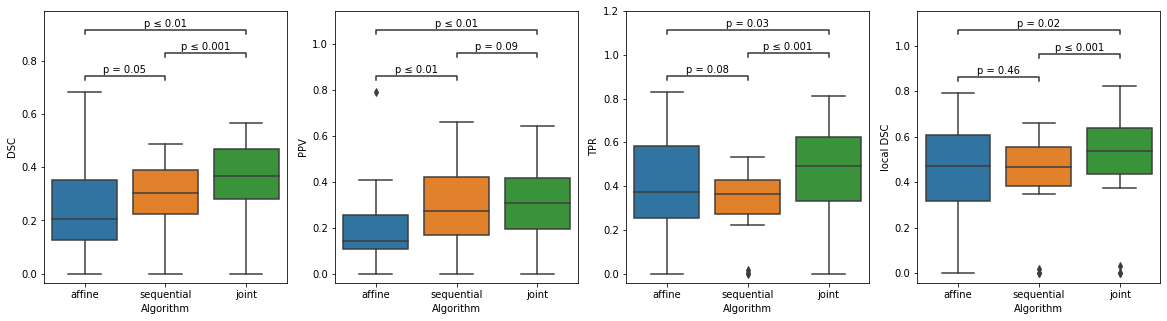

---------------------
MSEG_direct


DSC           PPV           TPR        local DSC       
           median    mad median    mad median    mad    median    mad
Algorithm                                                            
affine      0.011  0.042  0.006  0.024  0.681  0.291     0.541  0.220
sequential  0.031  0.099  0.017  0.088  0.436  0.223     0.535  0.227
joint       0.033  0.114  0.017  0.091  0.545  0.273     0.579  0.241

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n{} & \\multicolumn{2}{l}{DSC} & \\multicolumn{2}{l}{PPV} & \\multicolumn{2}{l}{TPR} & \\multicolumn{2}{l}{local DSC} \\\\\n{} &    median &       mad &    median &       mad &    median &       mad &    median &       mad \\\\\nAlgorithm  &           &           &           &           &           &           &           &           \\\\\n\\midrule\naffine     &  0.011073 &  0.041949 &  0.005571 &  0.024341 &  0.681178 &  0.291462 &  0.541199 &  0.219947 \\\\\nsequential &  0.031196 &  0.099222 &  0.017149 &  0.087572 &  0.436364 &  0.223286 &  0.535294 &  0.227062 \\\\\njoint      &  0.032757 &  0.113686 &  0.017229 &  0.090618 &  0.545151 &  0.273156 &  0.579365 &  0.240609 \\\\\n\\bottomrule\n\\end{tabular}\n'

DSC


/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,24.0,two-sided,2.164449e-09,6.493347e-09,fdr_bh,-0.525831
1,Algorithm,affine,sequential,True,False,43.0,two-sided,6.365428e-09,9.548143e-09,fdr_bh,-0.509210
2,Algorithm,joint,sequential,True,False,429.0,two-sided,1.040215e-01,1.040215e-01,fdr_bh,0.062063


PPV


/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,22.0,two-sided,1.928644e-09,3.246674e-09,fdr_bh,-0.522246
1,Algorithm,affine,sequential,True,False,24.0,two-sided,2.164449e-09,3.246674e-09,fdr_bh,-0.515797
2,Algorithm,joint,sequential,True,False,556.0,two-sided,7.466338e-01,7.466338e-01,fdr_bh,0.011853


TPR


/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,0.0,two-sided,1.145126e-09,1.717688e-09,fdr_bh,0.335046
1,Algorithm,affine,sequential,True,False,0.0,two-sided,5.299947e-10,1.589984e-09,fdr_bh,0.604019
2,Algorithm,joint,sequential,True,False,0.0,two-sided,3.640620e-09,3.640620e-09,fdr_bh,0.254531


local DSC


/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,634.0,two-sided,0.789358,0.789358,fdr_bh,0.030095
1,Algorithm,affine,sequential,True,False,412.0,two-sided,0.018872,0.028308,fdr_bh,0.138843
2,Algorithm,joint,sequential,True,False,223.0,two-sided,0.000314,0.000943,fdr_bh,0.104017


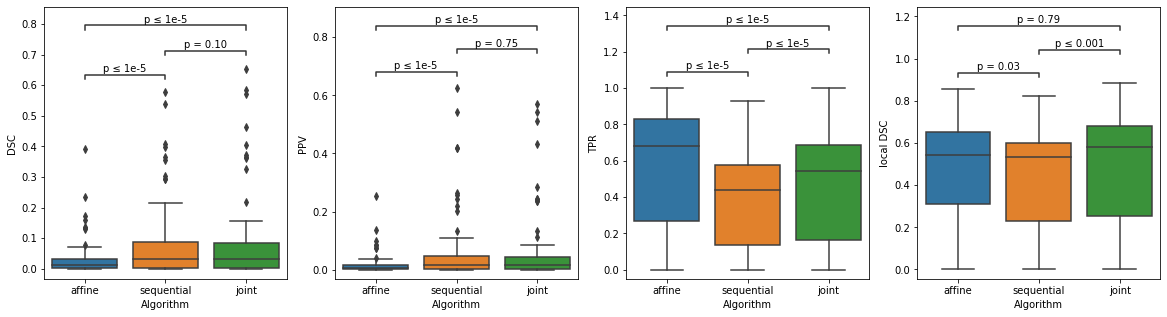

---------------------
MSEG_inverse


DSC           PPV           TPR        local DSC       
           median    mad median    mad median    mad    median    mad
Algorithm                                                            
affine      0.011  0.042  0.006  0.024  0.681  0.291     0.541  0.220
sequential  0.045  0.124  0.023  0.097  0.599  0.286     0.582  0.240
joint       0.041  0.120  0.021  0.092  0.628  0.296     0.593  0.242

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n{} & \\multicolumn{2}{l}{DSC} & \\multicolumn{2}{l}{PPV} & \\multicolumn{2}{l}{TPR} & \\multicolumn{2}{l}{local DSC} \\\\\n{} &    median &       mad &    median &       mad &    median &       mad &    median &       mad \\\\\nAlgorithm  &           &           &           &           &           &           &           &           \\\\\n\\midrule\naffine     &  0.011073 &  0.041949 &  0.005571 &  0.024341 &  0.681178 &  0.291462 &  0.541199 &  0.219947 \\\\\nsequential &  0.044561 &  0.123676 &  0.023119 &  0.097078 &  0.599448 &  0.285722 &  0.581940 &  0.240434 \\\\\njoint      &  0.041437 &  0.120282 &  0.021435 &  0.092311 &  0.627648 &  0.296248 &  0.592965 &  0.241620 \\\\\n\\bottomrule\n\\end{tabular}\n'

DSC


/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,17.0,two-sided,1.443317e-09,2.164975e-09,fdr_bh,-0.558672
1,Algorithm,affine,sequential,True,False,17.0,two-sided,1.443317e-09,2.164975e-09,fdr_bh,-0.587149
2,Algorithm,joint,sequential,True,False,195.0,two-sided,3.353604e-05,3.353604e-05,fdr_bh,-0.028970


PPV


/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,17.0,two-sided,1.443317e-09,2.164975e-09,fdr_bh,-0.539568
1,Algorithm,affine,sequential,True,False,17.0,two-sided,1.443317e-09,2.164975e-09,fdr_bh,-0.566620
2,Algorithm,joint,sequential,True,False,77.0,two-sided,1.027440e-07,1.027440e-07,fdr_bh,-0.033985


TPR


/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,95.0,two-sided,1.904082e-06,1.904082e-06,fdr_bh,0.101265
1,Algorithm,affine,sequential,True,False,10.0,two-sided,1.565224e-08,4.695672e-08,fdr_bh,0.171546
2,Algorithm,joint,sequential,True,False,11.0,two-sided,8.491666e-08,1.273750e-07,fdr_bh,0.068522


local DSC


/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,205.0,two-sided,0.000018,0.000054,fdr_bh,-0.112385
1,Algorithm,affine,sequential,True,False,315.0,two-sided,0.001125,0.001687,fdr_bh,-0.095482
2,Algorithm,joint,sequential,True,False,433.0,two-sided,0.242398,0.242398,fdr_bh,0.016618


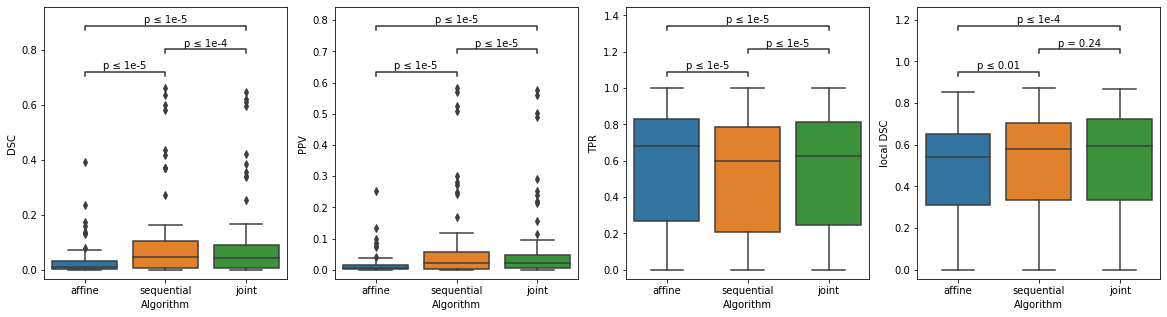

In [63]:
dico={"Lesjack":(listPatientIdLesjackComplet,"direct"),
      "MSEG_direct":(listPatientIdWithEvolutionComplet,"direct"),
      "MSEG_inverse":(listPatientIdWithEvolutionComplet,"inverse")}

for k,v in dico.items() :
    print("---------------------")
    print(k)
    dfselect=df[(df["patientId"].isin(v[0]))&(df["sens"]==v[1])]
    res=dfselect.groupby(["Algorithm"])[metrics].agg(["median","mad"]).reindex(index = ['affine','sequential','joint'])
    display(res.round(3))
    display(res.to_latex())
    plt.figure(figsize=(20,5))
    for i,met in enumerate(metrics):
        print(met)
        plt.subplot(1,4,i+1)
        ax= sns.boxplot(data=dfselect,y=met,x="Algorithm",order=["affine","sequential","joint"])
        posthoc = pg.pairwise_ttests(data=dfselect, dv=met, within='Algorithm', subject='patientId', parametric=False, padjust='fdr_bh', effsize='hedges')
        display(posthoc)
        box_pairs=[("affine", "sequential"), ("joint", "sequential"), ("affine", "joint")]
        pvalues=[]
        for item in box_pairs :
            pvalues.append(posthoc[(posthoc["A"]==item[0]) & (posthoc["B"]==item[1])]['p-corr'].values[0])
        test_results = add_stat_annotation(ax, data=dfselect, y=met,x="Algorithm", order=["affine","sequential","joint"], box_pairs=box_pairs,
                                               perform_stat_test=False, pvalues=pvalues, test_short_name=None,
                                       text_format='simple', verbose=0)
    plt.savefig(k+".pdf")
    plt.show()
    

---------------------
MSEG_direct_withoutDectection


,median,mad
Algorithm,,
affine,14.186795,21.918688
sequential,1.551112,4.151825
joint,1.728779,4.857183


'\\begin{tabular}{lrr}\n\\toprule\n{} &     median &        mad \\\\\nAlgorithm  &            &            \\\\\n\\midrule\naffine     &  14.186795 &  21.918688 \\\\\nsequential &   1.551112 &   4.151825 \\\\\njoint      &   1.728779 &   4.857183 \\\\\n\\bottomrule\n\\end{tabular}\n'

/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,0.0,two-sided,0.000013,0.000013,fdr_bh,0.821869
1,Algorithm,affine,sequential,True,False,0.0,two-sided,0.000013,0.000013,fdr_bh,0.860236
2,Algorithm,joint,sequential,True,False,0.0,two-sided,0.000013,0.000013,fdr_bh,0.094977


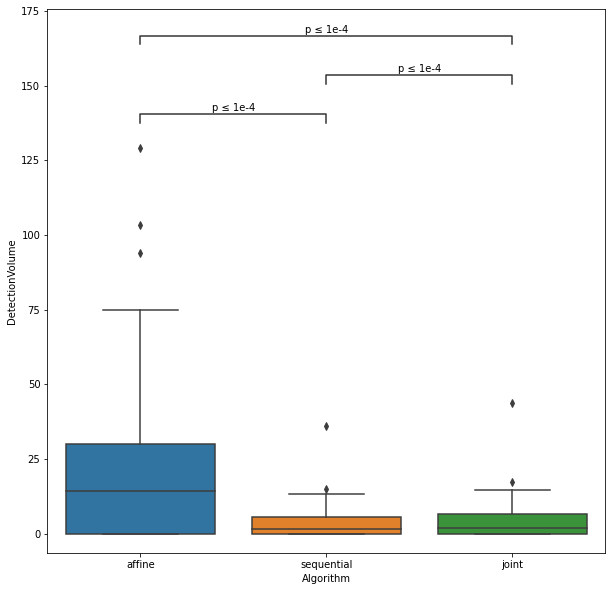

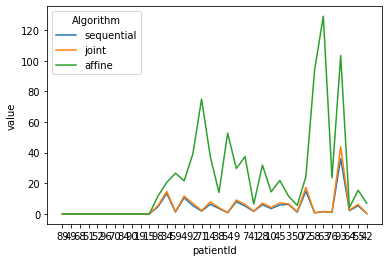

---------------------
MSEG_inverse_withoutDectection


,median,mad
Algorithm,,
affine,14.186795,21.918688
sequential,1.631894,4.166676
joint,1.959779,4.831229


'\\begin{tabular}{lrr}\n\\toprule\n{} &     median &        mad \\\\\nAlgorithm  &            &            \\\\\n\\midrule\naffine     &  14.186795 &  21.918688 \\\\\nsequential &   1.631894 &   4.166676 \\\\\njoint      &   1.959779 &   4.831229 \\\\\n\\bottomrule\n\\end{tabular}\n'

/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,0.0,two-sided,0.000013,0.000020,fdr_bh,0.817836
1,Algorithm,affine,sequential,True,False,0.0,two-sided,0.000013,0.000020,fdr_bh,0.854814
2,Algorithm,joint,sequential,True,False,0.0,two-sided,0.000029,0.000029,fdr_bh,0.090147


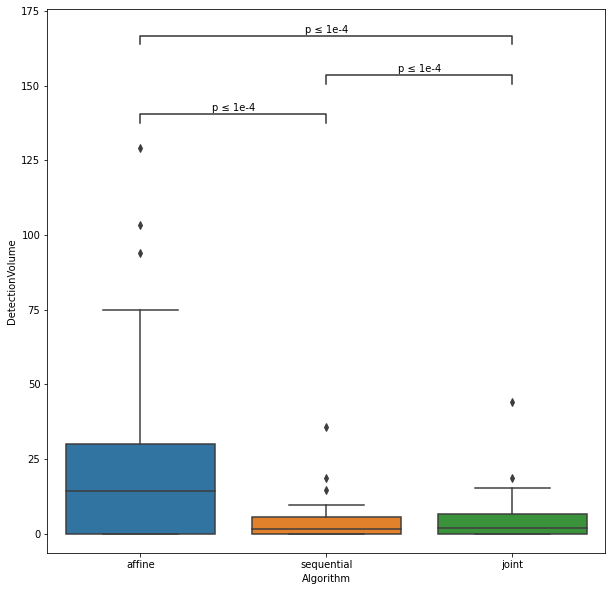

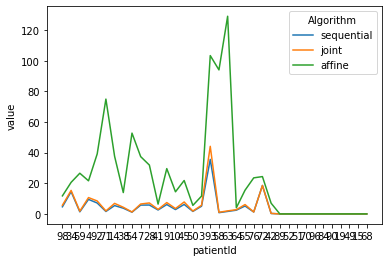

In [64]:
dico={"MSEG_direct_withoutDectection":(listPatientIdWithoutEvolutionComplet,"direct"),
      "MSEG_inverse_withoutDectection":(listPatientIdWithoutEvolutionComplet,"inverse")}

for k,v in dico.items() :
    print("---------------------")
    print(k)
    dfselect=df[(df["patientId"].isin(v[0]))&(df["sens"]==v[1])]
    res=dfselect.groupby(["Algorithm"])["DetectionVolume"].agg(["median","mad"]).reindex(index = ['affine','sequential','joint'])
    display(res)
    display(res.to_latex())
    plt.figure(figsize=(10,10))
    plt.subplot(1,1,1)
    ax= sns.boxplot(data=dfselect,y="DetectionVolume",x="Algorithm",order=["affine","sequential","joint"])
    posthoc = pg.pairwise_ttests(data=dfselect, dv="DetectionVolume", within='Algorithm', subject='patientId', parametric=False, padjust='fdr_bh', effsize='hedges')
    display(posthoc)
    box_pairs=[("affine", "sequential"), ("joint", "sequential"), ("affine", "joint")]
    pvalues=[]
    for item in box_pairs :
        pvalues.append(posthoc[(posthoc["A"]==item[0]) & (posthoc["B"]==item[1])]['p-corr'].values[0])
    test_results = add_stat_annotation(ax, data=dfselect, y="DetectionVolume",x="Algorithm", order=["affine","sequential","joint"], box_pairs=box_pairs,
                                           perform_stat_test=False, pvalues=pvalues, test_short_name=None,
                                   text_format='simple', verbose=0)
    plt.savefig(k+".pdf")
    plt.show()
    
    dftmp=dfselect.melt(id_vars=["patientId","Algorithm"],value_vars=["DetectionVolume"])
    sns.lineplot(data=dftmp,x="patientId",y="value",hue="Algorithm")
    plt.show()
    

---------------------
MSEG_direct_withoutDectection


,median,mad
Algorithm,,
affine,14.186795,21.918688
sequential,1.551112,4.151825
joint,1.728779,4.857183


'\\begin{tabular}{lrr}\n\\toprule\n{} &     median &        mad \\\\\nAlgorithm  &            &            \\\\\n\\midrule\naffine     &  14.186795 &  21.918688 \\\\\nsequential &   1.551112 &   4.151825 \\\\\njoint      &   1.728779 &   4.857183 \\\\\n\\bottomrule\n\\end{tabular}\n'

/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,0.0,two-sided,0.000013,0.000013,fdr_bh,0.821869
1,Algorithm,affine,sequential,True,False,0.0,two-sided,0.000013,0.000013,fdr_bh,0.860236
2,Algorithm,joint,sequential,True,False,0.0,two-sided,0.000013,0.000013,fdr_bh,0.094977


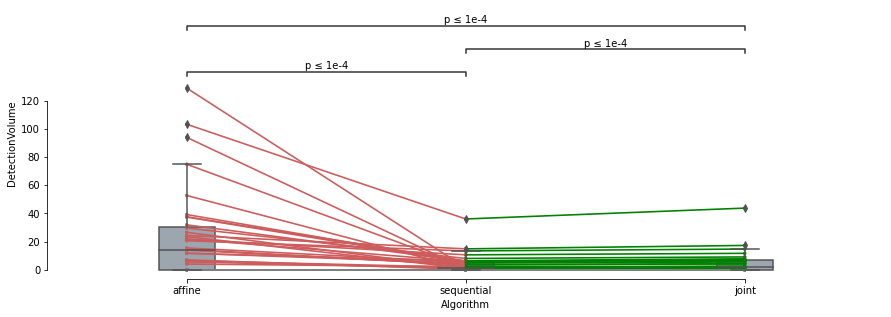

---------------------
MSEG_inverse_withoutDectection


,median,mad
Algorithm,,
affine,14.186795,21.918688
sequential,1.631894,4.166676
joint,1.959779,4.831229


'\\begin{tabular}{lrr}\n\\toprule\n{} &     median &        mad \\\\\nAlgorithm  &            &            \\\\\n\\midrule\naffine     &  14.186795 &  21.918688 \\\\\nsequential &   1.631894 &   4.166676 \\\\\njoint      &   1.959779 &   4.831229 \\\\\n\\bottomrule\n\\end{tabular}\n'

/usr/local/lib/python3.7/dist-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges
0,Algorithm,affine,joint,True,False,0.0,two-sided,0.000013,0.000020,fdr_bh,0.817836
1,Algorithm,affine,sequential,True,False,0.0,two-sided,0.000013,0.000020,fdr_bh,0.854814
2,Algorithm,joint,sequential,True,False,0.0,two-sided,0.000029,0.000029,fdr_bh,0.090147


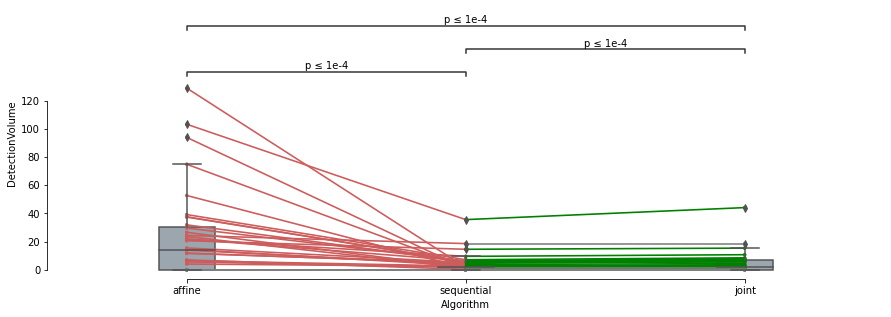

In [65]:
dico={"MSEG_direct_withoutDectection":(listPatientIdWithoutEvolutionComplet,"direct"),
      "MSEG_inverse_withoutDectection":(listPatientIdWithoutEvolutionComplet,"inverse")}

for k,v in dico.items() :
    print("---------------------")
    print(k)
    dfselect=df[(df["patientId"].isin(v[0]))&(df["sens"]==v[1])]
    #dfselect.DetectionVolume = 1000*dfselect.DetectionVolume
    res=dfselect.groupby(["Algorithm"])["DetectionVolume"].agg(["median","mad"]).reindex(index = ['affine','sequential','joint'])
    display(res)
    display(res.to_latex())
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    #ax.set_yscale('log')
    #ax.set_ylabel('Detection Volume', labelpad=20)
    pg.plot_paired(ax=ax,data=dfselect, dv="DetectionVolume", within='Algorithm', subject='patientId', boxplot=True,order=["affine","sequential","joint"])
        
    #ax= sns.boxplot(data=dfselect,y="DetectionVolume",x="Algorithm",order=["affine","sequential","joint"])
    posthoc = pg.pairwise_ttests(data=dfselect, dv="DetectionVolume", within='Algorithm', subject='patientId', parametric=False, padjust='fdr_bh', effsize='hedges')
    display(posthoc)
    box_pairs=[("affine", "sequential"), ("joint", "sequential"), ("affine", "joint")]
    pvalues=[]
    for item in box_pairs :
        pvalues.append(posthoc[(posthoc["A"]==item[0]) & (posthoc["B"]==item[1])]['p-corr'].values[0])
    test_results = add_stat_annotation(ax, data=dfselect, y="DetectionVolume",x="Algorithm", order=["affine","sequential","joint"], box_pairs=box_pairs,
                                           perform_stat_test=False, pvalues=pvalues, test_short_name=None,
                                   text_format='simple', verbose=0)
    plt.savefig(k+".pdf")
    plt.show()

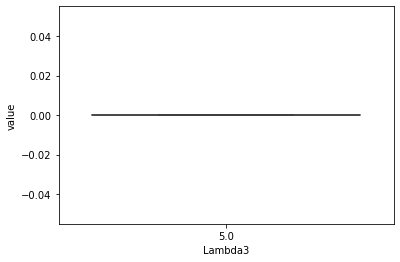

In [66]:
sns.boxplot(data=df[df["OriginDataset"]=="lesjak_isotrope"].melt(id_vars="Lambda3", value_vars="Dice_dilGT"),x="Lambda3",y="value")

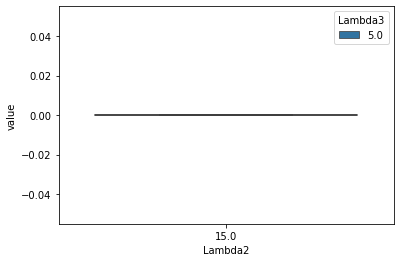

In [67]:
sns.boxplot(data=df[df["OriginDataset"]=="lesjak_isotrope"].melt(id_vars=["Lambda2","Lambda3"], value_vars="Dice_dilGT"),x="Lambda2",hue="Lambda3",y="value")

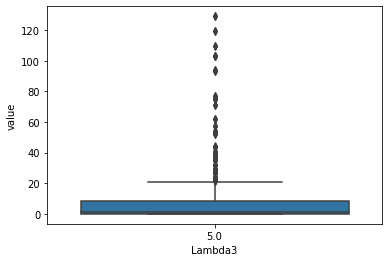

In [68]:
sns.boxplot(data=df.melt(id_vars="Lambda3", value_vars="Dice_dilGT"),x="Lambda3",y="value")

In [69]:
df.melt(id_vars="Lambda3", value_vars="Dice").groupby("Lambda3").median()

,value
Lambda3,
5.0,1.253719


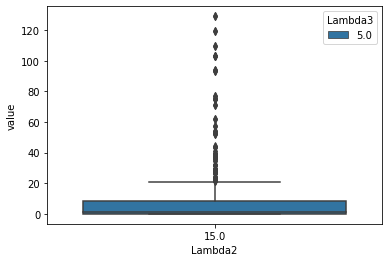

In [70]:
sns.boxplot(data=df.melt(id_vars=["Lambda2","Lambda3"], value_vars="Dice_dilGT"),x="Lambda2",hue="Lambda3",y="value")

In [71]:
df[(df["FPR"]==0)]

,OriginDataset,Algorithm,patientId,Lambda1,Lambda2,Lambda3,ADMMiterations,gtDilation,DSC,Jaccard,PPV,TPR,FPR,LTPR,LFPR,VD,SD,TPR_dilGT,FPR_dilGT,local DSC,LTPR_dilGT,LFPR_dilGT,VD_dilGT,SD_dilGT,sens,Vol,DetectionVolume


In [74]:
import collections

dfconcat=[]
for item in glob.glob("csv/*/*.csv") :
    if item not in listFiles :
        name=item.split("/")[1]
        df = pd.read_csv(item, sep=';')
        if len(dfconcat)==0 :
            colref=df.columns
            print(len(colref))
            
        df=df.drop_duplicates()
        df.columns=[x.replace(" ","") for x in df.columns]
       # if len(df.columns) != 24 :
       #     print(len(df.columns), df.columns)
      #      df = df.iloc[: , :-1]
      #  if not (collections.Counter(df.columns) == collections.Counter(colref)) :
      #      print(item,df.columns, colref )
        df["OriginDataset"]=name
        dfconcat.append(df)
print(len(dfconcat))

df = pd.read_csv('csv/msseg-affine/MSSEG2-Training_resampled_affine__seq_lastItr.csv', sep=';')
df=df.drop_duplicates()
df.columns=[x.replace(" ","") for x in df.columns]
df["OriginDataset"]="msseg-training-direct"
dfconcat.append(df)
df = pd.read_csv('csv/msseg-affine/MSSEG2-Training_resampled_affine__seq_lastItr.csv', sep=';')
df=df.drop_duplicates()
df.columns=[x.replace(" ","") for x in df.columns]
df["OriginDataset"]="msseg-training-inv"
dfconcat.append(df)

df = pd.read_csv('csv/msseg-affine/MSSEG2-Test_resampled_affine__seq_lastItr.csv', sep=';')
df=df.drop_duplicates()
df.columns=[x.replace(" ","") for x in df.columns]
df["OriginDataset"]="msseg-testing-direct"
dfconcat.append(df)
df = pd.read_csv('csv/msseg-affine/MSSEG2-Test_resampled_affine__seq_lastItr.csv', sep=';')
df=df.drop_duplicates()
df.columns=[x.replace(" ","") for x in df.columns]
df["OriginDataset"]="msseg-testing-inv"
dfconcat.append(df)

df = pd.read_csv('csv/lesjak_isotrope/Lesjak_nyul_affine_seq_lastItr.csv', sep=';')
df=df.drop_duplicates()
df.columns=[x.replace(" ","") for x in df.columns]
df["OriginDataset"]="lesjak_isotrope"
dfconcat.append(df)

df=pd.concat(dfconcat)
df["ADMMiterations"]=df["ADMMiterations"].apply(lambda x : x.replace(" ",""))
df=df[df["ADMMiterations"].isin(["0/0","1/5","5/5"])]
tr={"0/0":"affine","1/5":"sequential","5/5":"joint"}
df["Algorithm"]=df["ADMMiterations"].apply(lambda x : tr[x])
    
df=df[~df["Lambda3"].isin([7,9])]
df=df[df["Lambda3"]==5]
df=df[df["Lambda2"]==15]

dfall=df.copy()
dfnull=df.copy()
print("All")

listPatientIdWithoutEvolution=dfall[(dfall["SD"]==-1)&(dfall["Algorithm"]=="affine")]["patientId"].unique()
listPatientIdWithEvolution=dfall[(dfall["SD"]!=-1)&(dfall["Algorithm"]=="affine")&(dfall["OriginDataset"]!="lesjak_isotrope")]["patientId"].unique()
listPatientIdLesjack=dfall[dfall["OriginDataset"]=="lesjak_isotrope"]["patientId"].unique()



display(df.groupby(["OriginDataset","Algorithm"])[["patientId"]].count())
df=df[~df["patientId"].isin(listPatientIdWithoutEvolution)]
dfnull=dfnull[dfnull["patientId"].isin(listPatientIdWithoutEvolution)]

print("Not Null")
display(df.groupby(["OriginDataset","Algorithm"])[["patientId"]].count())
#display(df.groupby(["OriginDataset","Algorithm"])["patientId"].unique())

print("Null")
display(dfnull.groupby(["OriginDataset","Algorithm"])[["patientId"]].count())



#res=(df[df["OriginDataset"]!="lesjak_isotrope"].groupby(["patientId","Lambda2","Lambda3"])[["Algorithm"]].count()>5).reset_index()
#patientId=res[~res["Algorithm"]]["patientId"].tolist()

for dataset in sorted(df["OriginDataset"].unique()) :
    dfselect=df[df["OriginDataset"]==dataset]
    res=(dfselect.groupby(["patientId","Lambda2","Lambda3"])[["Algorithm"]].count()==3).reset_index()
    patientId=res[~res["Algorithm"]]["patientId"].tolist()
    print(dataset,patientId)
    df=df[(~df["patientId"].isin(patientId))|(df["OriginDataset"]!=dataset)]

    
for dataset in sorted(dfnull["OriginDataset"].unique()) :
    dfselect=dfnull[dfnull["OriginDataset"]==dataset]
    res=(dfselect.groupby(["patientId","Lambda2","Lambda3"])[["Algorithm"]].count()==3).reset_index()
    patientId=res[~res["Algorithm"]]["patientId"].tolist()
    print(dataset,patientId)
    dfnull=dfnull[(~dfnull["patientId"].isin(patientId))|(dfnull["OriginDataset"]!=dataset)]
dfnull["FPR"]=dfnull["FPR"]*10000

df=df.sort_values(["OriginDataset","patientId","Algorithm"])
display(df.groupby(["OriginDataset","Algorithm","Lambda2","Lambda3"])[["patientId"]].count())
display(dfnull.groupby(["OriginDataset","Algorithm","Lambda2","Lambda3"])[["patientId"]].count())

#df.groupby(["Lambda2","Lambda3"]).count()



listPatientIdWithoutEvolution=dfall[(dfall["SD"]==-1)&(dfall["Algorithm"]=="affine")]["patientId"].unique()
len(listPatientIdWithoutEvolution)

len(dfall[(dfall["SD"]==-1)&(dfall["Algorithm"]=="affine")]["patientId"].unique())

24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


220
All


patientId
OriginDataset         Algorithm            
lesjak_isotrope       affine             20
                      joint              20
                      sequential         20
msseg-affine          affine            100
msseg-testing-direct  affine             60
                      joint              60
                      sequential         61
msseg-testing-inv     affine             60
                      joint              57
                      sequential         57
msseg-training-direct affine             40
                      joint              40
                      sequential         40
msseg-training-inv    affine             40
                      joint              37
                      sequential         40

Not Null


patientId
OriginDataset         Algorithm            
lesjak_isotrope       affine             20
                      joint              20
                      sequential         20
msseg-affine          affine             61
msseg-testing-direct  affine             32
                      joint              32
                      sequential         33
msseg-testing-inv     affine             32
                      joint              32
                      sequential         32
msseg-training-direct affine             29
                      joint              29
                      sequential         29
msseg-training-inv    affine             29
                      joint              27
                      sequential         29

Null


patientId
OriginDataset         Algorithm            
msseg-affine          affine             39
msseg-testing-direct  affine             28
                      joint              28
                      sequential         28
msseg-testing-inv     affine             28
                      joint              25
                      sequential         25
msseg-training-direct affine             11
                      joint              11
                      sequential         11
msseg-training-inv    affine             11
                      joint              10
                      sequential         11

lesjak_isotrope []
msseg-affine [1, 2, 5, 6, 8, 11, 12, 13, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 43, 44, 46, 47, 48, 53, 56, 57, 60, 61, 62, 66, 67, 69, 74, 75, 77, 78, 80, 81, 82, 83, 85, 86, 87, 88, 91, 94, 95, 97, 99, 100]
msseg-testing-direct [33]
msseg-testing-inv []
msseg-training-direct []
msseg-training-inv [29, 30]
msseg-affine [3, 4, 7, 9, 10, 14, 15, 19, 28, 34, 38, 41, 42, 45, 49, 50, 51, 52, 54, 55, 58, 59, 63, 64, 65, 68, 70, 71, 72, 73, 76, 79, 84, 89, 90, 92, 93, 96, 98]
msseg-testing-direct []
msseg-testing-inv [65, 73, 79]
msseg-training-direct []
msseg-training-inv [15]


patientId
OriginDataset         Algorithm  Lambda2 Lambda3           
lesjak_isotrope       affine     15.0    5.0             20
                      joint      15.0    5.0             20
                      sequential 15.0    5.0             20
msseg-testing-direct  affine     15.0    5.0             31
                      joint      15.0    5.0             31
                      sequential 15.0    5.0             31
msseg-testing-inv     affine     15.0    5.0             32
                      joint      15.0    5.0             32
                      sequential 15.0    5.0             32
msseg-training-direct affine     15.0    5.0             29
                      joint      15.0    5.0             29
                      sequential 15.0    5.0             29
msseg-training-inv    affine     15.0    5.0             27
                      joint      15.0    5.0             27
                      sequential 15.0    5.0             27

patientId
OriginDataset         Algorithm  Lambda2 Lambda3           
msseg-testing-direct  affine     15.0    5.0             28
                      joint      15.0    5.0             28
                      sequential 15.0    5.0             28
msseg-testing-inv     affine     15.0    5.0             25
                      joint      15.0    5.0             25
                      sequential 15.0    5.0             25
msseg-training-direct affine     15.0    5.0             11
                      joint      15.0    5.0             11
                      sequential 15.0    5.0             11
msseg-training-inv    affine     15.0    5.0             10
                      joint      15.0    5.0             10
                      sequential 15.0    5.0             10

39

In [75]:
df = pd.read_csv('csv/lesjak_isotrope/Lesjak_nyul_affine_seq_lastItr.csv', sep=';')
df=df.drop_duplicates()
#df=df[df["Lambda2"]==15].sort_values("patientId")
len(df["patientId"].unique())
sorted(df["patientId"].unique())

['patient1',
 'patient10',
 'patient11',
 'patient12',
 'patient13',
 'patient14',
 'patient15',
 'patient16',
 'patient17',
 'patient18',
 'patient19',
 'patient2',
 'patient20',
 'patient3',
 'patient4',
 'patient5',
 'patient6',
 'patient7',
 'patient8',
 'patient9']

In [76]:
for item in [ 'csv/msseg-affine/MSSEG2-Training_resampled_affine__seq_lastItr.csv',
 'csv/msseg-affine/MSSEG2-Test_resampled_affine__seq_lastItr.csv',
           'csv/lesjak_isotrope/Lesjak_nyul_affine_seq_lastItr.csv'] :
    print(item)
    df = pd.read_csv(item, sep=';')
    df=df.drop_duplicates()
    display(df.groupby(["Lambda2","Lambda3"])[["Dice_dilGT"]].mean().reset_index().sort_values("Dice_dilGT",ascending=False))

csv/msseg-affine/MSSEG2-Training_resampled_affine__seq_lastItr.csv


,Lambda2,Lambda3,Dice_dilGT
0,15.0,5.0,0.47773


csv/msseg-affine/MSSEG2-Test_resampled_affine__seq_lastItr.csv


,Lambda2,Lambda3,Dice_dilGT
3,10.0,3.0,0.455358
6,15.0,3.0,0.451087
7,15.0,5.0,0.448506
9,25.0,3.0,0.443707
4,10.0,5.0,0.441848
10,25.0,5.0,0.436625
8,15.0,10.0,0.427118
5,10.0,10.0,0.418772
1,5.0,5.0,0.394445
0,5.0,3.0,0.387424


csv/lesjak_isotrope/Lesjak_nyul_affine_seq_lastItr.csv


,Lambda2,Lambda3,Dice_dilGT
2,10.0,3.0,0.516708
4,15.0,3.0,0.515451
6,20.0,3.0,0.490306
3,10.0,5.0,0.484034
8,25.0,3.0,0.466293
7,20.0,5.0,0.445864
10,30.0,3.0,0.440426
5,15.0,5.0,0.436146
0,5.0,3.0,0.418712
1,5.0,5.0,0.417965


In [77]:
for item in listFiles :
    df = pd.read_csv(item, sep=';')
    if len(df.columns) != 24 :
            print(item, len(df.columns), df.columns)

In [78]:
dfall[dfall['OriginDataset']=="msseg-testing-direct"].sort_values("patientId").groupby(["OriginDataset","patientId"])[["patientId"]].count()

patientId
OriginDataset        patientId           
msseg-testing-direct 1                  3
                     2                  3
                     3                  3
                     4                  3
                     5                  3
                     6                  3
                     7                  3
                     8                  3
                     9                  3
                     10                 3
                     11                 3
                     12                 3
                     14                 3
                     17                 3
                     22                 3
                     23                 3
                     25                 3
                     28                 3
                     31                 3
                     33                 4
                     34                 3
                     36                 3
                     38                 3
                     40                 3
                     41                 3
                     42                 3
                     44                 3
                     45                 3
                     46                 3
                     50                 3
                     53                 3
                     54                 3
                     55                 3
                     56                 3
                     58                 3
                     59                 3
                     60                 3
                     62                 3
                     63                 3
                     64                 3
                     65                 3
                     66                 3
                     67                 3
                     71                 3
                     72                 3
                     73                 3
                     75                 3
                     76                 3
                     78                 3
                     79                 3
                     80                 3
                     81                 3
                     82                 3
                     85                 3
                     86                 3
                     87                 3
                     92                 3
                     93                 3
                     97                 3
                     98                 3

In [79]:
res1=(dfall.groupby(["OriginDataset","patientId"])["Algorithm"].count()).reset_index()
res2=(dfall.groupby(["OriginDataset","patientId"])["Algorithm"].unique()).reset_index()
print(res2[res1["Algorithm"]<3])

          OriginDataset patientId             Algorithm
20         msseg-affine         1              [affine]
21         msseg-affine         2              [affine]
22         msseg-affine         3              [affine]
23         msseg-affine         4              [affine]
24         msseg-affine         5              [affine]
25         msseg-affine         6              [affine]
26         msseg-affine         7              [affine]
27         msseg-affine         8              [affine]
28         msseg-affine         9              [affine]
29         msseg-affine        10              [affine]
30         msseg-affine        11              [affine]
31         msseg-affine        12              [affine]
32         msseg-affine        13              [affine]
33         msseg-affine        14              [affine]
34         msseg-affine        15              [affine]
35         msseg-affine        16              [affine]
36         msseg-affine        17              [

In [80]:
dfall[dfall["SD"]==-1].groupby(["OriginDataset","Algorithm"]).count()

patientId  Lambda1  Lambda2  Lambda3  \
OriginDataset         Algorithm                                          
msseg-affine          affine             39       39       39       39   
msseg-testing-direct  affine             28       28       28       28   
                      joint              28       28       28       28   
                      sequential         28       28       28       28   
msseg-testing-inv     affine             28       28       28       28   
                      joint              25       25       25       25   
                      sequential         25       25       25       25   
msseg-training-direct affine             11       11       11       11   
                      joint              11       11       11       11   
                      sequential         11       11       11       11   
msseg-training-inv    affine             11       11       11       11   
                      joint              10       10       10       10   
                      sequential         11       11       11       11   

                                  ADMMiterations  gtDilation  Dice  Jaccard  \
OriginDataset         Algorithm                                               
msseg-affine          affine                  39          39    39       39   
msseg-testing-direct  affine                  28          28    28       28   
                      joint                   28          28    28       28   
                      sequential              28          28    28       28   
msseg-testing-inv     affine                  28          28    28       28   
                      joint                   25          25    25       25   
                      sequential              25          25    25       25   
msseg-training-direct affine                  11          11    11       11   
                      joint                   11          11    11       11   
                      sequential              11          11    11       11   
msseg-training-inv    affine                  11          11    11       11   
                      joint                   10          10    10       10   
                      sequential              11          11    11       11   

                                  PPV  TPR  FPR  LTPR  LFPR  VD  SD  \
OriginDataset         Algorithm                                       
msseg-affine          affine       39    0   39     0    39  39  39   
msseg-testing-direct  affine       28    0   28     0    28  28  28   
                      joint        28    0   28     0    28  28  28   
                      sequential   28    0   28     0    28  28  28   
msseg-testing-inv     affine       28    0   28     0    28  28  28   
                      joint        25    0   25     0    25  25  25   
                      sequential   25    0   25     0    25  25  25   
msseg-training-direct affine       11    0   11     0    11  11  11   
                      joint        11    0   11     0    11  11  11   
                      sequential   11    0   11     0    11  11  11   
msseg-training-inv    affine       11    0   11     0    11  11  11   
                      joint        10    0   10     0    10  10  10   
                      sequential   11    0   11     0    11  11  11   

                                  TPR_dilGT  FPR_dilGT  Dice_dilGT  \
OriginDataset         Algorithm                                      
msseg-affine          affine              0         39           0   
msseg-testing-direct  affine              0         28           0   
                      joint               0         28           0   
                      sequential          0         28           0   
msseg-testing-inv     affine              0         28           0   
                      joint               0         25           0   
                      sequential          0         25           0   
msseg-training-direct affine             

In [81]:
dfall.groupby(["OriginDataset","Algorithm"]).count()

patientId  Lambda1  Lambda2  Lambda3  \
OriginDataset         Algorithm                                          
lesjak_isotrope       affine             20       20       20       20   
                      joint              20       20       20       20   
                      sequential         20       20       20       20   
msseg-affine          affine            100      100      100      100   
msseg-testing-direct  affine             60       60       60       60   
                      joint              60       60       60       60   
                      sequential         61       61       61       61   
msseg-testing-inv     affine             60       60       60       60   
                      joint              57       57       57       57   
                      sequential         57       57       57       57   
msseg-training-direct affine             40       40       40       40   
                      joint              40       40       40       40   
                      sequential         40       40       40       40   
msseg-training-inv    affine             40       40       40       40   
                      joint              37       37       37       37   
                      sequential         40       40       40       40   

                                  ADMMiterations  gtDilation  Dice  Jaccard  \
OriginDataset         Algorithm                                               
lesjak_isotrope       affine                  20          20    20       20   
                      joint                   20          20    20       20   
                      sequential              20          20    20       20   
msseg-affine          affine                 100         100   100      100   
msseg-testing-direct  affine                  60          60    60       60   
                      joint                   60          60    60       60   
                      sequential              61          61    61       61   
msseg-testing-inv     affine                  60          60    60       60   
                      joint                   57          57    57       57   
                      sequential              57          57    57       57   
msseg-training-direct affine                  40          40    40       40   
                      joint                   40          40    40       40   
                      sequential              40          40    40       40   
msseg-training-inv    affine                  40          40    40       40   
                      joint                   37          37    37       37   
                      sequential              40          40    40       40   

                                  PPV  TPR  FPR  LTPR  LFPR   VD   SD  \
OriginDataset         Algorithm                                         
lesjak_isotrope       affine       20   20   20    20    20   20   20   
                      joint        20   20   20    20    20   20   20   
                      sequential   20   20   20    20    20   20   20   
msseg-affine          affine      100   61  100    61   100  100  100   
msseg-testing-direct  affine       60   32   60    32    60   60   60   
                      joint        60   32   60    32    60   60   60   
                      sequential   61   33   61    33    61   61   61   
msseg-testing-inv     affine       60   32   60    32    60   60   60   
                      joint        57   32   57    32    57   57   57   
                      sequential   57   32   57    32    57   57   57   
msseg-training-direct affine       40   29   40    29    40   40   40   
                      joint        40   29   40    29    40   40   40   
                      sequential   40   29   40    29    40   40   40   
msseg-training-inv    affine       40   29   40    29    40   40   40   
                      joint        37   27   37    27    37   37   37   
                      sequential   40

In [82]:
sorted(df[(df["OriginDataset"]=="lesjak_isotrope")&(df["Algorithm"]=="joint")]["patientId"])

[]

In [83]:
dfnull.groupby(["OriginDataset","Algorithm","Lambda2","Lambda3"]).agg(['mean','std'])


patientId             \
                                                       mean        std   
OriginDataset         Algorithm  Lambda2 Lambda3                         
msseg-testing-direct  affine     15.0    5.0      49.892857  28.198160   
                      joint      15.0    5.0      49.892857  28.198160   
                      sequential 15.0    5.0      49.892857  28.198160   
msseg-testing-inv     affine     15.0    5.0      47.200000  28.634187   
                      joint      15.0    5.0      47.200000  28.634187   
                      sequential 15.0    5.0      47.200000  28.634187   
msseg-training-direct affine     15.0    5.0      62.090909  27.750512   
                      joint      15.0    5.0      62.090909  27.750512   
                      sequential 15.0    5.0      62.090909  27.750512   
msseg-training-inv    affine     15.0    5.0      66.800000  24.178962   
                      joint      15.0    5.0      66.800000  24.178962   
                      sequential 15.0    5.0      66.800000  24.178962   

                                                 Lambda1      gtDilation       \
                                                    mean  std       mean  std   
OriginDataset         Algorithm  Lambda2 Lambda3                                
msseg-testing-direct  affine     15.0    5.0         0.0  0.0        4.0  0.0   
                      joint      15.0    5.0        70.0  0.0        4.0  0.0   
                      sequential 15.0    5.0        70.0  0.0        4.0  0.0   
msseg-testing-inv     affine     15.0    5.0         0.0  0.0        4.0  0.0   
                      joint      15.0    5.0        70.0  0.0        4.0  0.0   
                      sequential 15.0    5.0        70.0  0.0        4.0  0.0   
msseg-training-direct affine     15.0    5.0         0.0  0.0        4.0  0.0   
                      joint      15.0    5.0        70.0  0.0        4.0  0.0   
                      sequential 15.0    5.0        70.0  0.0        4.0  0.0   
msseg-training-inv    affine     15.0    5.0         0.0  0.0        4.0  0.0   
                      joint      15.0    5.0        70.0  0.0        4.0  0.0   
                      sequential 15.0    5.0        70.0  0.0        4.0  0.0   

                                                 Dice      Jaccard       PPV  \
                                                 mean  std    mean  std mean   
OriginDataset         Algorithm  Lambda2 Lambda3                               
msseg-testing-direct  affine     15.0    5.0      0.0  0.0     0.0  0.0  0.0   
                      joint      15.0    5.0      0.0  0.0     0.0  0.0  0.0   
                      sequential 15.0    5.0      0.0  0.0     0.0  0.0  0.0   
msseg-testing-inv     affine     15.0    5.0      0.0  0.0     0.0  0.0  0.0   
                      joint      15.0    5.0      0.0  0.0     0.0  0.0  0.0   
                      sequential 15.0    5.0      0.0  0.0     0.0  0.0  0.0   
msseg-training-direct affine     15.0    5.0      0.0  0.0     0.0  0.0  0.0   
                      joint      15.0    5.0      0.0  0.0     0.0  0.0  0.0   
                      sequential 15.0    5.0      0.0  0.0     0.0  0.0  0.0   
msseg-training-inv    affine     15.0    5.0      0.0  0.0     0.0  0.0  0.0   
                      joint      15.0    5.0      0.0  0.0     0.0  0.0  0.0   
                      sequential 15.0    5.0      0.0  0.0     0.0  0.0  0.0   

                                                       TPR            FPR  \
                                                  std mean std       mean   
OriginDataset         Algorithm  Lambda2 Lambda3                            
msseg-testing-direct  affine     15.0    5.0      0.0  NaN NaN  31.483571   
                      joint      15.0    5.0      0.0  NaN NaN   6.355714   
                      sequential 15.0    5.0      0.0  NaN NaN   5.448214   
msseg-testing-inv     affine     15.0    5.0      0.0  NaN N

In [85]:
df.groupby(["OriginDataset","Algorithm","Lambda2","Lambda3"])[metrics].agg(['mean','std'])


KeyError: ignored

In [ ]:
df.groupby(["OriginDataset","Algorithm","Lambda2","Lambda3"])["Dice_dilGT"].mean()


In [ ]:
for met in metrics :
    plt.figure(figsize=(10,5))
    plt.title(met)
    ax= sns.boxplot(data=df,y="OriginDataset",x=met,hue="Algorithm",hue_order=["affine","sequential","joint"])
    plt.show()

In [ ]:
for dataset in sorted(df["OriginDataset"].unique()) :
    dfselect=df[df["OriginDataset"]==dataset]
    plt.figure(figsize=(20,5))
    for i,met in enumerate(metrics):
        plt.subplot(1,4,i+1)
    
        print(dataset, met)
        ax= sns.boxplot(data=dfselect,y=met,x="Algorithm",order=["affine","sequential","joint"])
        #dfselect=dfselect.melt(id_vars=["patientId","Algorithm"],value_vars=["Dice_dilGT"])
        aov = pg.rm_anova(dv=met, within='Algorithm',subject='patientId', data=dfselect, detailed=True, effsize="np2")
        #display(aov)
        posthoc = pg.pairwise_ttests(data=dfselect, dv=met, within='Algorithm', subject='patientId', parametric=False, padjust='fdr_bh', effsize='hedges')
        display(posthoc)
        
        box_pairs=[("affine", "sequential"), ("joint", "sequential"), ("affine", "joint")]
        pvalues=[]
        for item in box_pairs :
            pvalues.append(posthoc[(posthoc["A"]==item[0]) & (posthoc["B"]==item[1])]['p-corr'].values[0])
        test_results = add_stat_annotation(ax, data=dfselect, y=met,x="Algorithm", order=["affine","sequential","joint"], box_pairs=box_pairs,
                                           perform_stat_test=False, pvalues=pvalues, test_short_name="pairwise ttest",
                                   text_format='star', verbose=0)
    plt.show()

In [ ]:
for dataset in [["lesjak_isotrope"],["msseg-testing-direct","msseg-training-direct"],["msseg-testing-inv","msseg-training-inv"]] :
    dfselect=df[df["OriginDataset"].isin(dataset)]
    plt.figure(figsize=(20,5))
    for i,met in enumerate(metrics):
        plt.subplot(1,4,i+1)
    
        print(dataset, met)
        ax= sns.boxplot(data=dfselect,y=met,x="Algorithm",order=["affine","sequential","joint"])
        #dfselect=dfselect.melt(id_vars=["patientId","Algorithm"],value_vars=["Dice_dilGT"])
        aov = pg.rm_anova(dv=met, within='Algorithm',subject='patientId', data=dfselect, detailed=True, effsize="np2")
        #display(aov)
        posthoc = pg.pairwise_ttests(data=dfselect, dv=met, within='Algorithm', subject='patientId', parametric=False, padjust='fdr_bh', effsize='hedges')
        display(posthoc)
        
        box_pairs=[("affine", "sequential"), ("joint", "sequential"), ("affine", "joint")]
        pvalues=[]
        for item in box_pairs :
            pvalues.append(posthoc[(posthoc["A"]==item[0]) & (posthoc["B"]==item[1])]['p-corr'].values[0])
        test_results = add_stat_annotation(ax, data=dfselect, y=met,x="Algorithm", order=["affine","sequential","joint"], box_pairs=box_pairs,
                                           perform_stat_test=False, pvalues=pvalues, test_short_name="pairwise ttest",
                                   text_format='star', verbose=0)
    plt.show()

In [ ]:
for dataset in [["lesjak_isotrope"],["msseg-testing-direct","msseg-training-direct"],["msseg-testing-inv","msseg-training-inv"]] :
    dfselect=df[df["OriginDataset"].isin(dataset)]
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    for i,met in enumerate(metrics):
    
        print(dataset, met)
        pg.plot_paired(ax=ax[i],data=dfselect, dv=met, within='Algorithm', subject='patientId', boxplot=True,order=["affine","sequential","joint"])
        
        #ax= sns.boxplot(data=dfselect,y=met,x="Algorithm",order=["affine","sequential","joint"])
        #dfselect=dfselect.melt(id_vars=["patientId","Algorithm"],value_vars=["Dice_dilGT"])
        aov = pg.rm_anova(dv=met, within='Algorithm',subject='patientId', data=dfselect, detailed=True, effsize="np2")
        #display(aov)
        posthoc = pg.pairwise_ttests(data=dfselect, dv=met, within='Algorithm', subject='patientId', parametric=False, padjust='fdr_bh', effsize='hedges')
        display(posthoc)
        
        box_pairs=[("affine", "sequential"), ("joint", "sequential"), ("affine", "joint")]
        pvalues=[]
        for item in box_pairs :
            pvalues.append(posthoc[(posthoc["A"]==item[0]) & (posthoc["B"]==item[1])]['p-corr'].values[0])
        test_results = add_stat_annotation(ax[i], data=dfselect, y=met,x="Algorithm", order=["affine","sequential","joint"], box_pairs=box_pairs,
                                           perform_stat_test=False, pvalues=pvalues, test_short_name="pairwise ttest",
                                   text_format='star', verbose=0)
    plt.show()

In [ ]:
for dataset in [["msseg-testing-direct","msseg-training-direct"],["msseg-testing-inv","msseg-training-inv"]] :
    dfselect=dfnull[dfnull["OriginDataset"].isin(dataset)]
    #display(dfselect)
    plt.figure(figsize=(5,5))
    for i,met in enumerate(["FPR"]):
        plt.subplot(1,1,i+1)
    
        print(dataset, met)
        ax= sns.boxplot(data=dfselect,y=met,x="Algorithm",order=["affine","sequential","joint"])
        #dfselect=dfselect.melt(id_vars=["patientId","Algorithm"],value_vars=["Dice_dilGT"])
        #aov = pg.rm_anova(dv=met, within='Algorithm',subject='patientId', data=dfselect, detailed=True, effsize="np2")
        #display(aov)
        posthoc = pg.pairwise_ttests(data=dfselect, dv=met, within='Algorithm', subject='patientId', parametric=False, padjust='fdr_bh', effsize='hedges')
        display(posthoc)
        
        box_pairs=[("affine", "sequential"), ("joint", "sequential"), ("affine", "joint")]
        pvalues=[]
        for item in box_pairs :
            pvalues.append(posthoc[(posthoc["A"]==item[0]) & (posthoc["B"]==item[1])]['p-corr'].values[0])
        test_results = add_stat_annotation(ax, data=dfselect, y=met,x="Algorithm", box_pairs=box_pairs,order=["affine","sequential","joint"],
                                           perform_stat_test=False, pvalues=pvalues, test_short_name="pairwise ttest",
                                   text_format='star', verbose=0)
    plt.show()

In [ ]:
for dataset in [["msseg-testing-direct","msseg-training-direct"],["msseg-testing-inv","msseg-training-inv"]] :
    dfselect=dfnull[dfnull["OriginDataset"].isin(dataset)]
    #display(dfselect)
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    for i,met in enumerate(["FPR"]):
        print(dataset, met)
        pg.plot_paired(ax=ax,data=dfselect, dv=met, within='Algorithm', subject='patientId', boxplot=True,order=["affine","sequential","joint"])
        #dfselect=dfselect.melt(id_vars=["patientId","Algorithm"],value_vars=["Dice_dilGT"])
        #aov = pg.rm_anova(dv=met, within='Algorithm',subject='patientId', data=dfselect, detailed=True, effsize="np2")
        #display(aov)
        posthoc = pg.pairwise_ttests(data=dfselect, dv=met, within='Algorithm', subject='patientId', parametric=False, padjust='fdr_bh', effsize='hedges')
        display(posthoc)
        
        box_pairs=[("affine", "sequential"), ("joint", "sequential"), ("affine", "joint")]
        pvalues=[]
        for item in box_pairs :
            pvalues.append(posthoc[(posthoc["A"]==item[0]) & (posthoc["B"]==item[1])]['p-corr'].values[0])
        test_results = add_stat_annotation(ax1, data=dfselect, y=met,x="Algorithm", box_pairs=box_pairs,order=["affine","sequential","joint"],
                                           perform_stat_test=False, pvalues=pvalues, test_short_name="pairwise ttest",
                                   text_format='star', verbose=0)
        
    
    plt.show()
    dftmp=dfselect.melt(id_vars=["patientId","Algorithm"],value_vars=[met])
    sns.lineplot(data=dftmp,x="patientId",y="value",hue="Algorithm")

In [ ]:
dfselect[["Algorithm","patientId","FPR"]].sort_values("patientId")

In [ ]:
posthoc[(posthoc["A"]==item[0]) & (posthoc["B"]==item[1])]['p-corr'].values

In [ ]:
for met in metrics :
        #dfselect=dfselect.melt(id_vars=["patientId","Algorithm"],value_vars=["Dice_dilGT"])
    print(met)
    
    aov = pg.rm_anova(dv=met, within='Algorithm',subject='patientId', data=df, detailed=True, effsize="np2")
    display(aov)
    posthoc = pg.pairwise_ttests(data=df, dv=met, within='Algorithm', subject='patientId', parametric=True, padjust='fdr_bh', effsize='hedges')
    display(posthoc)
    

In [ ]:
dfselect=df[df["OriginDataset"]=="msseg-testing-direct"]
#dfselect=dfselect[dfselect["patientId"]==30]
#sns.scatterplot(data=dfselect,y='TPR', x='FPR',hue="Algorithm")
dfselect

In [ ]:
for dataset in sorted(df["OriginDataset"].unique()) :
    dfselect=df[df["OriginDataset"]==dataset]
    dfselect=dfselect.melt(id_vars=["patientId","Algorithm"],value_vars=["Dice_dilGT"])
    dfselect["patientId"]=dfselect["patientId"].apply(str)
    dfselect["patientId"]=dfselect["patientId"].apply(lambda x : x.replace("patient",""))
    dfselect["patientId"]=dfselect["patientId"].apply(int)
    dfselect=dfselect.sort_values("patientId")
    dfselect["patientId"]=dfselect["patientId"].apply(str)
    plt.figure(figsize=(15,5))
    plt.title(dataset)
    sns.lineplot(data=dfselect,x="patientId",y="value",hue="Algorithm")
    plt.show()

In [ ]:
df.columns

In [ ]:
df = pd.read_csv("csv/msseg-training-direct/MSSEG-2_training_asym_inv__joint_lastItr.csv", sep=';')
df1 = pd.read_csv( 'csv/msseg-affine/MSSEG2-Training_resampled_affine__seq_lastItr.csv', sep=';')
df=pd.concat((df,df1))
display(df.groupby('ADMMiterations').count())
df=df[df["patientId"]==13]
df=df[df["ADMMiterations"].isin(["0/0","1/5","5/5"])]
tr={"0/0":"affine","1/5":"sequential","5/5":"joint"}
df["Algorithm"]=df["ADMMiterations"].apply(lambda x : tr[x])
#dfdf.melt(id_vars=["Lambda2","Lambda3","Algorithm"],value_vars=["Dice_dilGT"]
sns.scatterplot(data=df,y='TPR', x='FPR',hue="Algorithm")

In [ ]:
for item in listFiles :
    print(item)
    print(os.path.basename(item))
    df = pd.read_csv(item, sep=';')
    df=df.drop_duplicates()
    ListePatient=sorted(df["patientId"].unique())
    nbPatient=len(ListePatient)
    print("nbPatient : ",nbPatient)
    print(ListePatient)
    print(sorted(df["ADMMiterations"].unique()))
    print("Lambda2",sorted(df["Lambda2"].unique()))
    print("Lambda3",sorted(df["Lambda3"].unique()))

In [ ]:
df = pd.read_csv("csv/msseg-affine/MSSEG2-Training_resampled_affine__seq_lastItr.csv", sep=';')
df=df.drop_duplicates()
df=df[df["patientId"]==13]
df

In [ ]:
df = pd.read_csv('csv/lesjak_isotrope/Lesjak_iso_asym_inv__joint_lastItr.csv', sep=';')
#df=df[df["patientId"]=='patient3']
len(df["patientId"].unique())
df=df[df["ADMMiterations"]=="5/5"]
sns.boxplot(data=df,x="Lambda2",y="Dice",hue="Lambda3")
plt.show()
sns.boxplot(data=df,x="Lambda3",y="Dice",hue="Lambda2")
df.groupby(["Lambda2","Lambda3"])["OriginDataset"].count()
#len(df["patientId"].unique())
df.columns

In [ ]:
df = pd.read_csv("csv/msseg-training-direct/MSSEG-2_training_asym_inv__joint_lastItr.csv", sep=';')
df1 = pd.read_csv( 'csv/msseg-affine/MSSEG2-Training_resampled_affine__seq_lastItr.csv', sep=';')
df=pd.concat((df,df1))
display(df.groupby('ADMMiterations').count())
df=df[df["patientId"]==13]
df=df[df["ADMMiterations"].isin(["0/0","1/5","5/5"])]
tr={"0/0":"affine","1/5":"sequential","5/5":"joint"}
df["Algorithm"]=df["ADMMiterations"].apply(lambda x : tr[x])
#dfdf.melt(id_vars=["Lambda2","Lambda3","Algorithm"],value_vars=["Dice_dilGT"]
sns.scatterplot(data=df,y='TPR', x='FPR',hue="Algorithm")